In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from timm import create_model
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the DeiT model and set the number of classes to 6
model = create_model('deit_base_distilled_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 6)  # Adjust for 6-class classification

# If the DeiT model has a distilled head, modify it as well
if hasattr(model, 'head_dist'):
    model.head_dist = nn.Linear(model.head_dist.in_features, 6)

# Load the state dictionary with map_location set to CPU
model.load_state_dict(torch.load("E:\\Kimi\\Penelitian\\Transformer_Skripsi\\Deit\\Deit_Biasa\\best_model3.pth", map_location=torch.device('cpu')))
model.eval()

# Set device to CPU
device = torch.device('cpu')
model.to(device)

C:\Users\USER\AppData\Local\Temp\ipykernel_14552\4215420235.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("E:\\Kimi\\Penelitian\\Tran

VisionTransformerDistilled(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): 

In [2]:
from tqdm import tqdm  # Import tqdm

# Define evaluation function with progress bar
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    y_score = []

    with torch.no_grad():
        # Wrap DataLoader with tqdm to display progress bar
        for images, labels in tqdm(dataloader, desc="Evaluating", unit="batch"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            # Calculate predictions and scores
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(outputs.cpu().numpy())
    
    return y_true, y_pred, y_score

In [3]:
# Set up transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),           # Resize images to 224x224 pixels
    transforms.ToTensor(),                   # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load your data into DataLoader (ensure val_loader and test_loader are properly defined)
# Load datasets
val_dataset = datasets.ImageFolder(root='E:\\Kimi\\Penelitian\\Dataset\\db_spine-ok\\val', transform=transform)
test_dataset = datasets.ImageFolder(root='E:\\Kimi\\Penelitian\\Dataset\\db_spine-ok\\test', transform=transform)

# Set up DataLoader
batch_size = 32
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# Evaluate on validation and test datasets
y_val_true, y_val_pred, y_val_score = evaluate_model(model, val_loader)
y_test_true, y_test_pred, y_test_score = evaluate_model(model, test_loader)

Evaluating: 100%|███████████████████████████████████████████████████████████████████| 20/20 [05:18<00:00, 15.91s/batch]


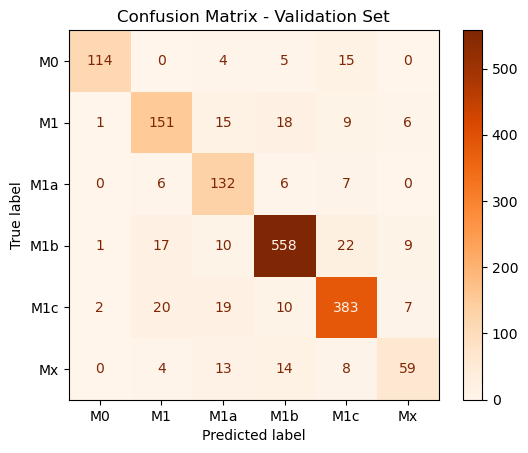

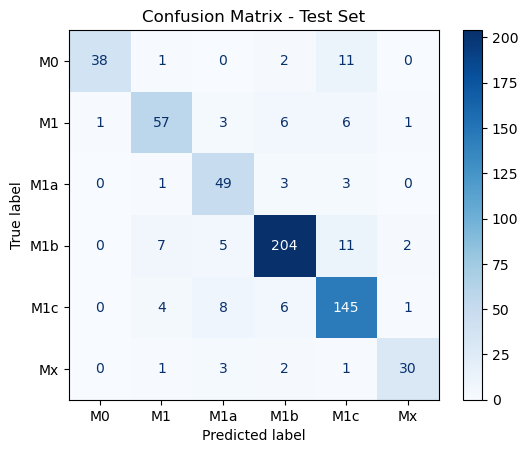

In [5]:
# Confusion Matrix for Validation Set
cm_val = confusion_matrix(y_val_true, y_val_pred)
ConfusionMatrixDisplay(cm_val, display_labels=['M0', 'M1', 'M1a', 'M1b', 'M1c', 'Mx']).plot(cmap="Oranges")
plt.title("Confusion Matrix - Validation Set")
plt.show()

# Confusion Matrix for Test Set
cm_test = confusion_matrix(y_test_true, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=['M0', 'M1', 'M1a', 'M1b', 'M1c', 'Mx']).plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

In [6]:
from sklearn.metrics import classification_report

# After evaluating on validation and test datasets

# Classification Report for Validation Set
print("Classification Report - Validation Set")
print(classification_report(y_val_true, y_val_pred, target_names=['M0', 'M1', 'M1a', 'M1b', 'M1c', 'Mx']))

# Classification Report for Test Set
print("Classification Report - Test Set")
print(classification_report(y_test_true, y_test_pred, target_names=['M0', 'M1', 'M1a', 'M1b', 'M1c', 'Mx']))

Classification Report - Validation Set
              precision    recall  f1-score   support

          M0       0.97      0.83      0.89       138
          M1       0.76      0.76      0.76       200
         M1a       0.68      0.87      0.77       151
         M1b       0.91      0.90      0.91       617
         M1c       0.86      0.87      0.87       441
          Mx       0.73      0.60      0.66        98

    accuracy                           0.85      1645
   macro avg       0.82      0.81      0.81      1645
weighted avg       0.85      0.85      0.85      1645

Classification Report - Test Set
              precision    recall  f1-score   support

          M0       0.97      0.73      0.84        52
          M1       0.80      0.77      0.79        74
         M1a       0.72      0.88      0.79        56
         M1b       0.91      0.89      0.90       229
         M1c       0.82      0.88      0.85       164
          Mx       0.88      0.81      0.85        37

    a

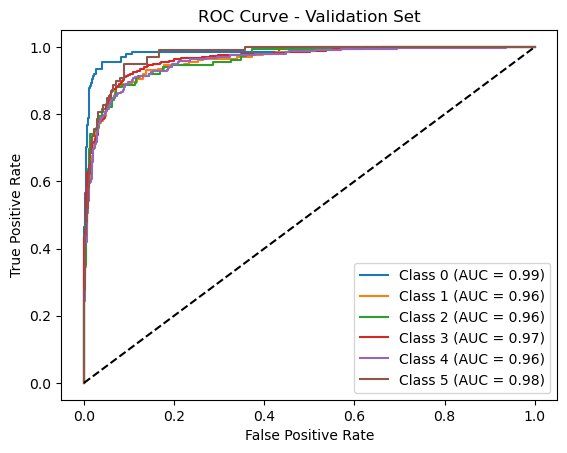

In [7]:
from sklearn.preprocessing import label_binarize

# ROC and AUC for Validation Set
y_val_true_binary = label_binarize(y_val_true, classes=[0, 1, 2, 3, 4, 5])  # Binarize for multi-class ROC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_val_true_binary[:, i], np.array(y_val_score)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
for i in range(6):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend(loc="best")
plt.show()

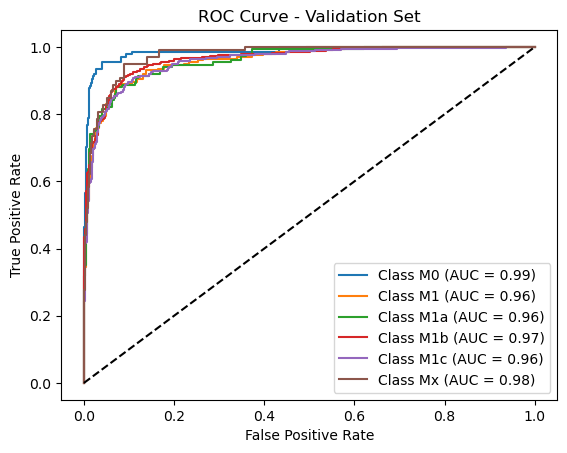

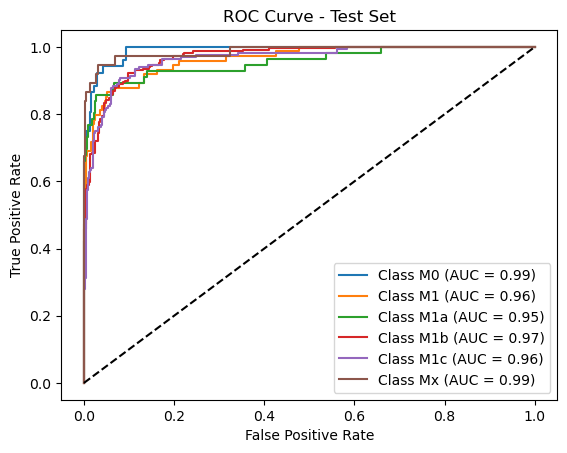

In [8]:
# ROC and AUC for Validation Set
y_val_true_binary = label_binarize(y_val_true, classes=[0, 1, 2, 3, 4, 5])  # Binarize for multi-class ROC
fpr_val, tpr_val, roc_auc_val = {}, {}, {}
for i in range(6):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_true_binary[:, i], np.array(y_val_score)[:, i])
    roc_auc_val[i] = auc(fpr_val[i], tpr_val[i])

# Plot ROC curves for each class in Validation Set
plt.figure()
for i in range(6):
    plt.plot(fpr_val[i], tpr_val[i], label=f"Class {val_dataset.classes[i]} (AUC = {roc_auc_val[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend(loc="best")
plt.show()

# ROC and AUC for Test Set
y_test_true_binary = label_binarize(y_test_true, classes=[0, 1, 2, 3, 4, 5])  # Binarize for multi-class ROC
fpr_test, tpr_test, roc_auc_test = {}, {}, {}
for i in range(6):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_true_binary[:, i], np.array(y_test_score)[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Plot ROC curves for each class in Test Set
plt.figure()
for i in range(6):
    plt.plot(fpr_test[i], tpr_test[i], label=f"Class {test_dataset.classes[i]} (AUC = {roc_auc_test[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend(loc="best")
plt.show()


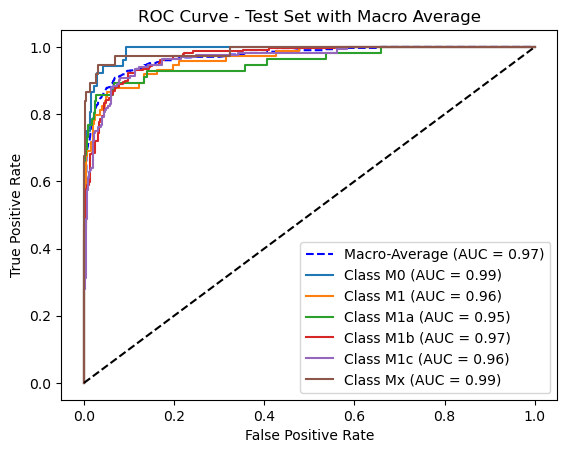

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Binarize the true labels for multi-class ROC
y_test_true_binary = label_binarize(y_test_true, classes=[0, 1, 2, 3, 4, 5])
fpr_test, tpr_test, roc_auc_test = {}, {}, {}

# Compute ROC curve and AUC for each class
for i in range(6):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_true_binary[:, i], np.array(y_test_score)[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Compute all FPR points and interpolate TPR values for macro average
all_fpr_test = np.unique(np.concatenate([fpr_test[i] for i in range(6)]))
mean_tpr_test = np.zeros_like(all_fpr_test)
for i in range(6):
    mean_tpr_test += np.interp(all_fpr_test, fpr_test[i], tpr_test[i])
mean_tpr_test /= 6  # Average TPR pada seluruh classes
macro_auc_test = auc(all_fpr_test, mean_tpr_test)

# Plot macro-average ROC curve dengan Test Set
plt.figure()
plt.plot(all_fpr_test, mean_tpr_test, label=f"Macro-Average (AUC = {macro_auc_test:.2f})", color="blue", linestyle="--")
for i in range(6):
    plt.plot(fpr_test[i], tpr_test[i], label=f"Class {test_dataset.classes[i]} (AUC = {roc_auc_test[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set with Macro Average")
plt.legend(loc="best")
plt.show()
